# Perform error analysis across collaborative tests and activities.


In [274]:
from justhink_problem.problem import init_problem, reset_problem
from justhink_problem.domain.state import WorldState
from justhink_problem.domain.action import *
import pathlib as pl
import pickle
import pandas as pd
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
#import wilcoxon signed-rank
from scipy.stats import wilcoxon, shapiro, ttest_rel, stats
#import cliffs delta
from effsize.effsize import two_group_difference

# Define paths.

In [2]:
processed_tables_pickle_file = pl.Path(
    '../processed_data/processed_tables.pickle')

# Load pickled data.

In [3]:
with processed_tables_pickle_file.open('rb') as handle:
    processed_tables = pickle.load(handle)

In [263]:
processed_tables.keys()
pd.options.display.max_columns = None
df = processed_tables[10]
df = df.loc[df['header.frame_id'] == 'collab-activity-2']
# df

# 1 Error over collab activity success.

### Cleaning Tables.

In [264]:
# formatting dataframe for error over best collaborative activity success
def clean_tables():
    student_tables = {}
    for student, df in processed_tables.items():
        #list of maximum error values for each activity
        max_error = []

        df = df.copy()
        df = df[df['is_submission']]

        df.drop(['Time', 'header.seq', 'state.edges', 'state.suggested.u', 'state.suggested.v', 'state.terminal', 'state.submit_suggested', 'action.type', 'action.edge.u', 'action.edge.v', 'turn_agent', 'next_state.edges', 'next_state.suggested.u', 'next_state.suggested.v',
                'next_state.terminal', 'next_state.submit_suggested', 'action_no', 'step_no'], axis=1, inplace=True)

        # removing collaborative activity rows
#         df = df[df['header.frame_id'] != "collab-activity"]
#         df = df[df['header.frame_id'] != "collab-activity-2"]
        # removing duplicate rows from submission log and keeping the last submission
#         df.drop_duplicates(subset="header.frame_id",
#                            keep='last', inplace=True)

        # preserving collaborative activity rows while removing duplicate test rows
        df = pd.concat([
            df[df['header.frame_id'] == 'collab-activity'],
            df[df['header.frame_id'] == 'collab-activity-2'],
            df[(df['header.frame_id'] != 'collab-activity') & (df['header.frame_id'] !=
                                                               'collab-activity-2')].drop_duplicates(['header.frame_id'], keep='last')
        ])

        mst_costs = []
        spanning = []
        norm_error = []

        for i, row in df.iterrows():
            cost = row['world_state'].get_mst_cost()
            span = row['world_state'].is_spanning()
            mst_costs.append(cost)
            spanning.append(span)
            # compute normalized error
            if span:
                norm_error.append((int(row['cost']) - int(row['world_state'].get_mst_cost())) /
                                  int(row['world_state'].get_mst_cost()))
                max_error.append((int(row['world_state'].get_max_cost()) - int(row['world_state'].get_mst_cost())) /
                                  int(row['world_state'].get_mst_cost()))
            else:
                norm_error.append(None)

        # adding mst_cost, spanning, and normalized_error columns
        df['mst_cost'] = mst_costs
        df['spanning'] = spanning
        df['normalized_error'] = norm_error

        student_tables[student] = df

        print("STUDENT", student)
#         display(df)
    return student_tables, max_error


all_tables, max_error = clean_tables()
print(max_error)

STUDENT 6
STUDENT 1
STUDENT 9
STUDENT 7
STUDENT 2
STUDENT 5
STUDENT 4
STUDENT 3
STUDENT 10
[1.9090909090909092, 2.085714285714286, 1.6, 1.6, 1.4285714285714286, 1.2, 1.6, 1.6, 1.6, 1.4285714285714286, 1.2, 1.6]


### Formatting collab submissions dataframe.

In [6]:
# formatting dataframe for collab activities only
cdf = pd.DataFrame()

#dictionary containing all collaborative attempts by each student
collab_attempts = {}

for key, mdf in all_tables.items():
    collab_df = mdf.loc[mdf['header.frame_id'].isin(
        ['collab-activity', 'collab-activity-2'])].copy()
    collab_df['student'] = key
    collab_df.drop(columns=['world_state', 'is_submission', 'is_mst', 'cost', 'mst_cost', 'spanning', 'action'
                            ], inplace=True)
    collab_df.rename(columns={"header.frame_id": "activity",
                     "action.agent_name": "agent", "normalized_error": "error"}, inplace=True)
    cdf = cdf.append(collab_df)
    collab_attempts[key] = collab_df
    
# dataframe containing all collaborative activity submissions 
cdf

,activity,agent,error,student
93,collab-activity,human,0.772727,6
103,collab-activity,robot,NaN,6
109,collab-activity,robot,NaN,6
118,collab-activity,robot,NaN,6
153,collab-activity,human,0.772727,6
181,collab-activity-2,human,0.542857,6
182,collab-activity-2,human,NaN,6
211,collab-activity-2,human,NaN,6
231,collab-activity-2,human,NaN,6
81,collab-activity,robot,0.727273,1


### Filtering human submissions.

In [7]:
# dataframe containing only human collaborative activity submissions
cdf_human = pd.DataFrame()

# removing robot submissions
for index, row in cdf.iterrows():
    cdf_human = cdf.loc[cdf['agent'].isin(
        ['human'])].copy()

display(cdf_human)

# reformatting dataframes with only human submissions so they are activity specific

collab_df_1 = cdf_human.loc[cdf_human['activity'].isin(
    ['collab-activity'])].copy()

collab_df_2 = cdf_human.loc[cdf_human['activity'].isin(
    ['collab-activity-2'])].copy()

display(collab_df_1)
display(collab_df_2)

,activity,agent,error,student
93,collab-activity,human,0.772727,6
153,collab-activity,human,0.772727,6
181,collab-activity-2,human,0.542857,6
182,collab-activity-2,human,NaN,6
211,collab-activity-2,human,NaN,6
231,collab-activity-2,human,NaN,6
105,collab-activity,human,0.318182,1
155,collab-activity,human,0.454545,1
220,collab-activity-2,human,0.342857,1
245,collab-activity-2,human,0.000000,1


,activity,agent,error,student
93,collab-activity,human,0.772727,6
153,collab-activity,human,0.772727,6
105,collab-activity,human,0.318182,1
155,collab-activity,human,0.454545,1
109,collab-activity,human,0.454545,9
143,collab-activity,human,0.727273,9
167,collab-activity,human,0.045455,9
65,collab-activity,human,NaN,7
93,collab-activity,human,0.000000,7
116,collab-activity,human,0.000000,2


,activity,agent,error,student
181,collab-activity-2,human,0.542857,6
182,collab-activity-2,human,NaN,6
211,collab-activity-2,human,NaN,6
231,collab-activity-2,human,NaN,6
220,collab-activity-2,human,0.342857,1
245,collab-activity-2,human,0.000000,1
225,collab-activity-2,human,0.342857,9
253,collab-activity-2,human,0.000000,9
116,collab-activity-2,human,NaN,7
143,collab-activity-2,human,NaN,7


### Filtering best submissions.

In [8]:

# making a new dataframe that only contains the best submissions in each activity per student

# takes a dataframe containing rows of submissions and returns a dataframe with the best submissions
def bestDf(df):

    best_df = pd.DataFrame()
    bdf = df.copy()
    current = bdf.iloc[[0][0]]['student']
    temp_dict = {}
    temp_df = pd.DataFrame()

    for index, row in bdf.iterrows():
        #print('current student', current)
        if current == row['student']:
            # compare the errors of every student so that we select the best in each activity
            # add them to a new df
            temp_df = temp_df.append(row)
            # sort based on error value
            temp_df.sort_values(
                by=['error'], inplace=True, ascending=True, na_position='last', ignore_index=True)

            # gets the dataframe row with the lowest error and adds it to a temporary dictionary
            # update dictionary with key as student, value as the temp df where the first row is the best
            temp_dict[current] = temp_df.iloc[0]
            #display(temp_df)
        else:
            current = row['student']
            temp_df = pd.DataFrame()
            
            # figure out how to compare the errors of every student so that we select the best in each activity
            # add them to a new df
            temp_df = temp_df.append(row)
            # sort based on error value
            temp_df.sort_values(
                by=['error'], inplace=True, ascending=True, na_position='last', ignore_index=True)

            # gets the dataframe row with the lowest error and adds it to a temporary dictionary
            # update dictionary with key as student, value as the temp df where the first row is the best
            temp_dict[current] = temp_df.iloc[0]
            #display(temp_df)

    # display(temp_dict)

    # now need to loop through the dictionary and for every item, the first row in the value is the best submission
    for student, temp in temp_dict.items():
        # appending best submission to best_df
        # display(temp)
        temp.name = student
        best_df = best_df.append(temp)
    return best_df


bestDf(collab_df_1)

,activity,agent,error,student
6,collab-activity,human,0.772727,6.0
1,collab-activity,human,0.318182,1.0
9,collab-activity,human,0.045455,9.0
7,collab-activity,human,0.000000,7.0
2,collab-activity,human,0.000000,2.0
5,collab-activity,human,0.318182,5.0
4,collab-activity,human,0.318182,4.0
3,collab-activity,human,0.000000,3.0
10,collab-activity,human,0.000000,10.0


### Creating best dataframes for visualization.

In [9]:
collab_dfs = [collab_df_1, collab_df_2]

collab_best = pd.DataFrame()

# creating dataframes with the best submission of each collaborative activity for every student
for df in collab_dfs:
    best = bestDf(df)
    display(best)
    collab_best = collab_best.append(best)

collab_best.drop(columns=['agent'], inplace=True)
collab_best

,activity,agent,error,student
6,collab-activity,human,0.772727,6.0
1,collab-activity,human,0.318182,1.0
9,collab-activity,human,0.045455,9.0
7,collab-activity,human,0.000000,7.0
2,collab-activity,human,0.000000,2.0
5,collab-activity,human,0.318182,5.0
4,collab-activity,human,0.318182,4.0
3,collab-activity,human,0.000000,3.0
10,collab-activity,human,0.000000,10.0


,activity,agent,error,student
6,collab-activity-2,human,0.542857,6.0
1,collab-activity-2,human,0.000000,1.0
9,collab-activity-2,human,0.000000,9.0
7,collab-activity-2,human,NaN,7.0
2,collab-activity-2,human,0.000000,2.0
5,collab-activity-2,human,0.000000,5.0
4,collab-activity-2,human,0.000000,4.0
3,collab-activity-2,human,0.057143,3.0
10,collab-activity-2,human,0.000000,10.0


,activity,error,student
6,collab-activity,0.772727,6.0
1,collab-activity,0.318182,1.0
9,collab-activity,0.045455,9.0
7,collab-activity,0.000000,7.0
2,collab-activity,0.000000,2.0
5,collab-activity,0.318182,5.0
4,collab-activity,0.318182,4.0
3,collab-activity,0.000000,3.0
10,collab-activity,0.000000,10.0
6,collab-activity-2,0.542857,6.0


### Visualization of error over collab activity by best submission.

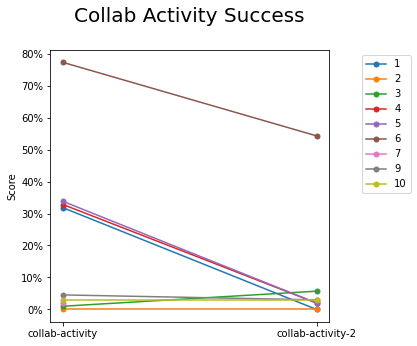

In [10]:
# visualization for error evolution over the best submission in each collaborative activity
students = [1, 2, 3, 4, 5, 6, 7, 9, 10]
separation = 0.01

# graphing the pretest versus posttest is_spanning scores
fig, ax = plt.subplots(1, figsize=(5, 5))

prelist = list()
postlist = list()
for i in students:
    temp = collab_best[collab_best['student'] == i]
    values = list(temp.error)
    #computing offset between overlapping lines
    p0 = values[0] + prelist.count(values[0])*separation
    p1 = values[1] + prelist.count(values[1])*separation
    prelist.append(values[0])
    postlist.append(values[1])
    #plotting
    plt.plot(temp.activity, [p0,p1], marker='o', markersize=5)
plt.ylabel('Score')
plt.title('Collab Activity Success\n', loc='center', fontsize=20)

leg = plt.legend(students, loc='upper left', frameon=True)
# get the bounding box of the original legend
bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
# change to location of the legend
xOffset = 1.1
bb.x0 += xOffset
bb.x1 += xOffset
leg.set_bbox_to_anchor(bb, transform=ax.transAxes)

# set y axis ticks to percentages
yticks = plt.yticks()[0]
plt.yticks(yticks[1:-1], [str(round(i*100)) + '%' for i in yticks[1:-1]])
plt.show()


## Compute temporal dynamics accross collaborative activities.

- Compare errors of best attempt in activity 1 vs. best attempt in activity 2 by Wilcoxon’s, and compute effect size Cliff’s Delta) (extension of notebook 3)
    - evolution overall significant if Wilcoxon’s says p < 0.05. 
    - Direction (improve or not) by Cliff’s Delta’s sign.
- Note: must be spanning, for collaborative activities
- report Magnitude overall: Cliff’s Delta’s absolute value (large, small, negligible, etc.)


### Reformatting best error dataframe. 

In [179]:
def reformat_collab_df(df):

    c_data = {}
    c2_data = {}

    for index,row in df.iterrows():
        if row['activity'] == 'collab-activity':
            if int(row['student']) not in c_data.keys():
                c_data[int(row['student'])] = row['error']
        if row['activity'] == 'collab-activity-2':
            if int(row['student']) not in c2_data.keys():
                c2_data[int(row['student'])] = row['error']

    df1 = pd.DataFrame.from_dict(data=c_data,orient='index',columns=['collab_error_1'])
    df2 = pd.DataFrame.from_dict(data=c2_data,orient='index',columns=['collab_error_2'])


    final_df = pd.merge(df1, df2, left_index=True, right_index=True)
    final_df['student'] = final_df.index
    return final_df

reformat_collab_df(collab_best)

,collab_error_1,collab_error_2,student
6,0.772727,0.542857,6
1,0.318182,0.000000,1
9,0.045455,0.000000,9
7,0.000000,NaN,7
2,0.000000,0.000000,2
5,0.318182,0.000000,5
4,0.318182,0.000000,4
3,0.000000,0.057143,3
10,0.000000,0.000000,10


### Perform Wilcoxon signed-rank test.

In [170]:
# df.dropna(inplace=True)

r = list(df['collab_error_1'])
o = list(df['collab_error_2'])
w, p = wilcoxon(r,o,mode="exact") 
#null hypotehsis says they are the same, p val less than threshold, reject hyp, conclude that post is larger than pretest
print('Exact:','W=',w,'pvalue=',p)
a,b = wilcoxon(r,o,mode="exact", alternative="greater")
print('Greater:','W=',a,'pvalue=',b)


Exact: W= 2.0 pvalue= 0.04105088656045887
Greater: W= 19.0 pvalue= 0.1973134331215476


### Compute effect size Cliff's Deltas.

In [171]:
r = list(df['collab_error_1'])
o = list(df['collab_error_2'])
# estimate effect size by Cliff's Delta 
d = two_group_difference(control=r, test=o, effect_size='cliffs_delta')
print('d', d)


d -0.3055555555555556


# 2 Error over collab activity by attempt.

In [172]:
custom_xticks = {}
for student, df in collab_attempts.items():
    # add attempt number column for graph
    df.reset_index(drop=True, inplace=True)
    df['attempt'] = df.index + 1
    count = 1
    labels = []
    for index, row in df.iterrows():
        if row['activity'] == 'collab-activity-2':
            # attempt = count
            # df.at[index,'attempt'] = attempt
            labels.append(count)
            count += 1
        else:
            labels.append(row['attempt'])
    custom_xticks[student] = labels
    display(df)

,activity,agent,error,student,attempt
0,collab-activity,human,0.772727,6,1
1,collab-activity,robot,NaN,6,2
2,collab-activity,robot,NaN,6,3
3,collab-activity,robot,NaN,6,4
4,collab-activity,human,0.772727,6,5
5,collab-activity-2,human,0.542857,6,6
6,collab-activity-2,human,NaN,6,7
7,collab-activity-2,human,NaN,6,8
8,collab-activity-2,human,NaN,6,9


,activity,agent,error,student,attempt
0,collab-activity,robot,0.727273,1,1
1,collab-activity,human,0.318182,1,2
2,collab-activity,robot,0.318182,1,3
3,collab-activity,human,0.454545,1,4
4,collab-activity-2,robot,NaN,1,5
5,collab-activity-2,human,0.342857,1,6
6,collab-activity-2,human,0.000000,1,7


,activity,agent,error,student,attempt
0,collab-activity,human,0.454545,9,1
1,collab-activity,human,0.727273,9,2
2,collab-activity,human,0.045455,9,3
3,collab-activity,robot,0.590909,9,4
4,collab-activity-2,human,0.342857,9,5
5,collab-activity-2,human,0.000000,9,6


,activity,agent,error,student,attempt
0,collab-activity,human,NaN,7,1
1,collab-activity,human,0.0,7,2
2,collab-activity-2,human,NaN,7,3
3,collab-activity-2,human,NaN,7,4
4,collab-activity-2,human,NaN,7,5
5,collab-activity-2,human,NaN,7,6


,activity,agent,error,student,attempt
0,collab-activity,human,0.0,2,1
1,collab-activity-2,human,0.2,2,2
2,collab-activity-2,human,NaN,2,3
3,collab-activity-2,human,NaN,2,4
4,collab-activity-2,human,NaN,2,5
5,collab-activity-2,human,NaN,2,6
6,collab-activity-2,human,0.0,2,7


,activity,agent,error,student,attempt
0,collab-activity,robot,0.727273,5,1
1,collab-activity,robot,0.409091,5,2
2,collab-activity,human,0.318182,5,3
3,collab-activity,human,NaN,5,4
4,collab-activity-2,human,0.000000,5,5


,activity,agent,error,student,attempt
0,collab-activity,human,0.454545,4,1
1,collab-activity,human,0.318182,4,2
2,collab-activity,human,0.363636,4,3
3,collab-activity,human,NaN,4,4
4,collab-activity-2,robot,NaN,4,5
5,collab-activity-2,human,NaN,4,6
6,collab-activity-2,human,0.000000,4,7


,activity,agent,error,student,attempt
0,collab-activity,robot,0.363636,3,1
1,collab-activity,human,0.318182,3,2
2,collab-activity,human,0.000000,3,3
3,collab-activity-2,robot,NaN,3,4
4,collab-activity-2,human,0.057143,3,5
5,collab-activity-2,human,0.114286,3,6
6,collab-activity-2,robot,0.057143,3,7


,activity,agent,error,student,attempt
0,collab-activity,human,0.0,10,1
1,collab-activity-2,human,0.0,10,2


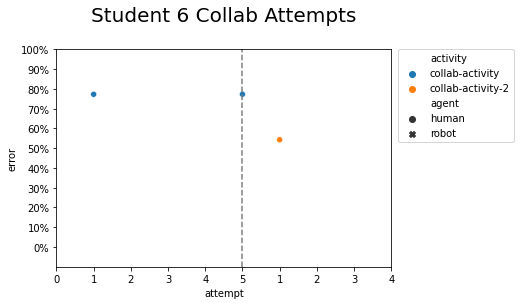

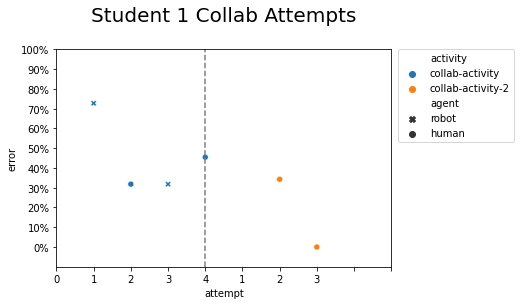

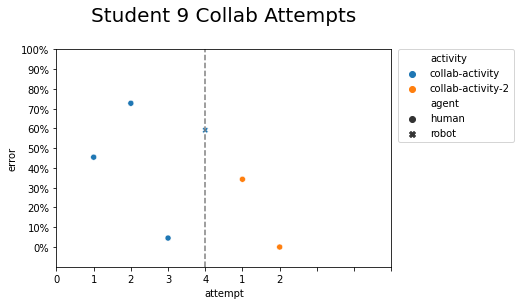

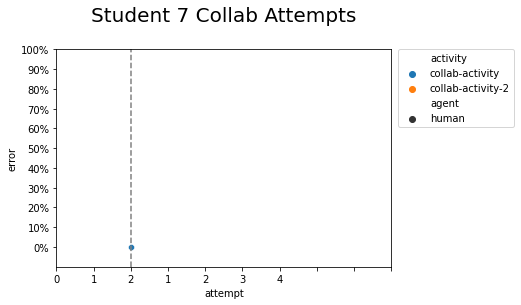

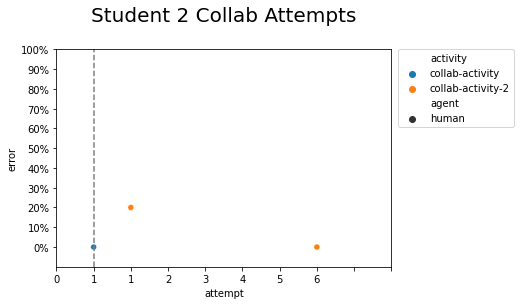

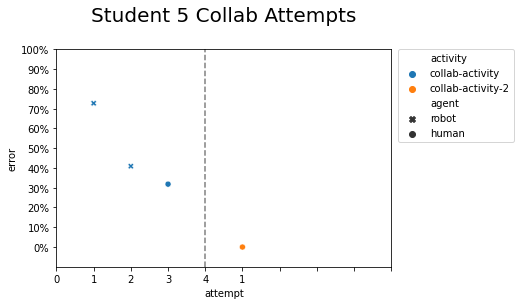

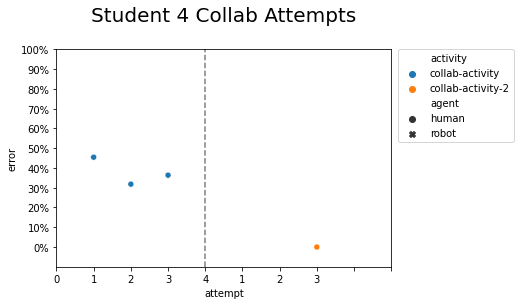

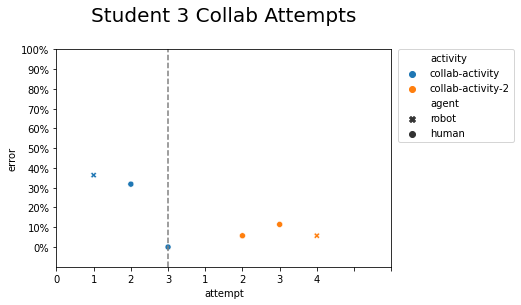

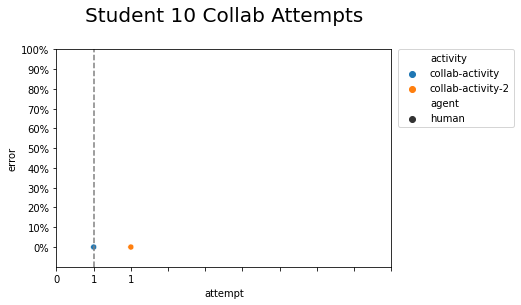

In [132]:
for student, df in collab_attempts.items():
    plt.figure()
    markers = {"human": "o", "robot": "X"}
    sns.scatterplot(data=df, x="attempt", y="error",
                    hue="activity", style="agent",markers=markers)
    plt.ylim(-0.1, 1)

    yticks = [-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1]
    plt.yticks(yticks[1:-1], [str(round(i*100)) + '%' for i in yticks[1:-1]])

    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    title = 'Student ' + str(int(df['student'][0])) + ' Collab Attempts\n'
    plt.title(title, loc='center', fontsize=20)

    # vertical line to divide plot by collaborative activity
    x = df.index[df['activity'] == 'collab-activity-2'].tolist()
    plt.axvline(x[0], 0, 1, ls='--', c='grey')

    # custom xticks for student attempts during each collab activity
    t = custom_xticks[student]
    if t[0] != 0:
        t.insert(0, 0)

    plt.xticks(np.arange(0, 10, 1.0), labels=t)

## Computing slope and p-value of linear regressions analysis.
Compare error progression among attempts in a collaborative activity by
computing the slope and p-value of a simple linear regression analysis 

### Reformatting dataframe.

In [173]:
collab_attempts


{6:             activity  agent     error  student  attempt
 0    collab-activity  human  0.772727        6        1
 1    collab-activity  robot       NaN        6        2
 2    collab-activity  robot       NaN        6        3
 3    collab-activity  robot       NaN        6        4
 4    collab-activity  human  0.772727        6        5
 5  collab-activity-2  human  0.542857        6        6
 6  collab-activity-2  human       NaN        6        7
 7  collab-activity-2  human       NaN        6        8
 8  collab-activity-2  human       NaN        6        9,
 1:             activity  agent     error  student  attempt
 0    collab-activity  robot  0.727273        1        1
 1    collab-activity  human  0.318182        1        2
 2    collab-activity  robot  0.318182        1        3
 3    collab-activity  human  0.454545        1        4
 4  collab-activity-2  robot       NaN        1        5
 5  collab-activity-2  human  0.342857        1        6
 6  collab-activity-2  h

In [222]:
linregress_df = pd.DataFrame()

stud = []
collab_p = []
collab_s = []
collab2_p = []
collab2_s = []

for student,df in collab_attempts.items():
    if student != 7:
        df.dropna(inplace=True)
#         df.fillna(0, inplace=True) #should the na's be replaced with the maximum error or not counted at all
        c1 = list(df.loc[df['activity'] == 'collab-activity']['error'])
        ac1 = list(df.loc[df['activity'] == 'collab-activity']['attempt'])
        c2 = list(df.loc[df['activity'] == 'collab-activity-2']['error'])
        ac2 = list(df.loc[df['activity'] == 'collab-activity-2']['attempt'])
        error = list(df['error'])
        attempt = list(df['attempt'])
#         print(c1,ac1,c2,ac2)

        slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(c1,ac1)
        slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(c2,ac2)
        print('Stud.',student, '| len c1:', len(c1), 'len c2:', len(c2))
        print('\tcollab-activity:','p_value1:', p_value1,'slope1:',slope1)
        print('\tcollab-activity-2:','p_value2:', p_value2,'slope2:',slope2)
        
        stud.append(student)
        collab_p.append(p_value1)
        collab_s.append(slope1)
        collab2_p.append(p_value2)
        collab2_s.append(slope2)

Stud. 6 | len c1: 2 len c2: 1
	collab-activity: p_value1: 0.0 slope1: nan
	collab-activity-2: p_value2: nan slope2: nan
Stud. 1 | len c1: 4 len c2: 2
	collab-activity: p_value1: 0.4522774424948337 slope1: -3.6666666666666674
	collab-activity-2: p_value2: 0.0 slope2: -2.9166666666666665
Stud. 9 | len c1: 4 len c2: 2
	collab-activity: p_value1: 0.8804771390665607 slope1: -0.5238095238095235
	collab-activity-2: p_value2: 0.0 slope2: -2.9166666666666665
Stud. 2 | len c1: 1 len c2: 2
	collab-activity: p_value1: nan slope1: nan
	collab-activity-2: p_value2: 0.0 slope2: -24.999999999999996
Stud. 5 | len c1: 3 len c2: 1
	collab-activity: p_value1: 0.19759612400303025 slope1: -4.432835820895521
	collab-activity-2: p_value2: nan slope2: nan
Stud. 4 | len c1: 3 len c2: 1
	collab-activity: p_value1: 0.5456289483429901 slope1: -9.428571428571427
	collab-activity-2: p_value2: nan slope2: nan
Stud. 3 | len c1: 3 len c2: 3
	collab-activity: p_value1: 0.2601469382930057 slope1: -4.631578947368421
	coll

/Users/alexandrachin/Desktop/data-justhink-spring21/analysis/venv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:160: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/Users/alexandrachin/Desktop/data-justhink-spring21/analysis/venv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:174: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/alexandrachin/Desktop/data-justhink-spring21/analysis/venv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:176: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/Users/alexandrachin/Desktop/data-justhink-spring21/analysis/venv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:160: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/Users/alexandrachin/Desktop/data-justhink-spring21/analysis/venv/li

In [219]:
linregress_df = pd.DataFrame()

linregress_df['student'] = stud
linregress_df['collab_pval'] = collab_p 
linregress_df['collab_slope'] = collab_s
linregress_df['collab2_pval'] = collab2_p
linregress_df['collab2_slope'] = collab2_s

linregress_df

,student,collab_pval,collab_slope,collab2_pval,collab2_slope
0,6,0.000000,NaN,NaN,NaN
1,1,0.452277,-3.666667,0.0,-2.916667
2,9,0.880477,-0.523810,0.0,-2.916667
3,2,NaN,NaN,0.0,-25.000000
4,5,0.197596,-4.432836,NaN,NaN
5,4,0.545629,-9.428571,NaN,NaN
6,3,0.260147,-4.631579,1.0,0.000000
7,10,NaN,NaN,NaN,NaN


In [221]:
significant = 0
for index,row in linregress_df.iterrows():
    if row['collab_pval'] < 0.05:
        significant +=1
percentage = (significant/len(linregress_df))*100
percentage

12.5

In [230]:
for student,df in collab_attempts.items():
    if student != 7:
        df.dropna(inplace=True)
#         df.fillna(0, inplace=True) #should the na's be replaced with the maximum error or not counted at all
        c1 = list(df.loc[df['activity'] == 'collab-activity']['error'])
        ac1 = list(df.loc[df['activity'] == 'collab-activity']['attempt'])
        c2 = list(df.loc[df['activity'] == 'collab-activity-2']['error'])
        ac2 = list(df.loc[df['activity'] == 'collab-activity-2']['attempt'])
        error = list(df['error'])
        attempt = list(df['attempt'])
#         print(c1,ac1,c2,ac2)

        rho1, pval1 = stats.spearmanr(c1, ac1, nan_policy='omit')
        rho2, pval2 = stats.spearmanr(c2, ac2, nan_policy='omit')
        print('Stud.',student, '| len c1:', len(c1), 'len c2:', len(c2))
        print('\tcollab-activity:','rho1:', rho1,'pval1:',pval1)
        print('\tcollab-activity-2:','rho2:', rho2,'pval2:',pval2)


Stud. 6 | len c1: 2 len c2: 1
	collab-activity: rho1: nan pval1: nan
	collab-activity-2: rho2: nan pval2: nan
Stud. 1 | len c1: 4 len c2: 2
	collab-activity: rho1: -0.316227766016838 pval1: 0.683772233983162
	collab-activity-2: rho2: -0.9999999999999999 pval2: nan
Stud. 9 | len c1: 4 len c2: 2
	collab-activity: rho1: 0.0 pval1: 1.0
	collab-activity-2: rho2: -0.9999999999999999 pval2: nan
Stud. 2 | len c1: 1 len c2: 2
	collab-activity: rho1: nan pval1: nan
	collab-activity-2: rho2: -0.9999999999999999 pval2: nan
Stud. 5 | len c1: 3 len c2: 1
	collab-activity: rho1: -1.0 pval1: 0.0
	collab-activity-2: rho2: nan pval2: nan
Stud. 4 | len c1: 3 len c2: 1
	collab-activity: rho1: -0.5 pval1: 0.6666666666666667
	collab-activity-2: rho2: nan pval2: nan
Stud. 3 | len c1: 3 len c2: 3
	collab-activity: rho1: -1.0 pval1: 0.0
	collab-activity-2: rho2: 0.0 pval2: 1.0
Stud. 10 | len c1: 1 len c2: 1
	collab-activity: rho1: nan pval1: nan
	collab-activity-2: rho2: nan pval2: nan


/Users/alexandrachin/Desktop/data-justhink-spring21/analysis/venv/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


# 3 Error over entire experiment evolution.

In [13]:
collab_best_copy = collab_best.copy()
# make dataframe for entire experiment for each student, using the best submissions of the collaborative activities
evolution_dfs = {}

for student,df in all_tables.items():
    print('student',student)
    # removing collaborative activity rows
    df = df[df['header.frame_id'] != "collab-activity"]
    df = df[df['header.frame_id'] != "collab-activity-2"]
    
    df.rename(columns={"header.frame_id": "activity",
                     "action.agent_name": "agent", "normalized_error": "error"}, inplace=True)
    
    # searching collab_best for collaborative activities of the student
    for index, row in collab_best_copy.iterrows():
        #if the student number of the best row matches the student
        if int(row['student']) == int(student):
            #then add the row of that student to the df
            df = df.append(row)
    
    # removing excess columns
    df.drop(columns=['world_state', 'is_submission', 'is_mst', 'cost', 'mst_cost', 'spanning', 'action'
                            ], inplace=True)
    
    # setting student column values
    df[['student']] = int(df.iloc[[-1][0]]['student'])
    
    #reset index
    df.reset_index(drop=True, inplace=True)
    
    #reorganizing dataframe so that collab activities are between tests
    posttests = df.loc[df['activity'].isin(['posttest-1','posttest-2','posttest-3','posttest-4','posttest-5'])]
    df = df.drop([5,6,7,8,9])
    df = df.append(posttests)
    df.reset_index(drop=True, inplace=True)
    
    #adding to dictionary
    evolution_dfs[student] = df
    display(df)
evolution_dfs


student 6


,activity,agent,error,student
0,pretest-1,human,0.266667,6
1,pretest-2,human,0.533333,6
2,pretest-3,human,0.238095,6
3,pretest-4,human,0.244444,6
4,pretest-5,human,0.266667,6
5,collab-activity,NaN,0.772727,6
6,collab-activity-2,NaN,0.542857,6
7,posttest-1,human,NaN,6
8,posttest-2,human,0.266667,6
9,posttest-3,human,0.238095,6


student 1


,activity,agent,error,student
0,pretest-1,human,0.533333,1
1,pretest-2,human,0.266667,1
2,pretest-3,human,0.047619,1
3,pretest-4,human,0.000000,1
4,pretest-5,human,0.000000,1
5,collab-activity,NaN,0.318182,1
6,collab-activity-2,NaN,0.000000,1
7,posttest-1,human,0.000000,1
8,posttest-2,human,0.000000,1
9,posttest-3,human,0.000000,1


student 9


,activity,agent,error,student
0,pretest-1,human,0.200000,9
1,pretest-2,human,1.600000,9
2,pretest-3,human,1.428571,9
3,pretest-4,human,1.200000,9
4,pretest-5,human,0.200000,9
5,collab-activity,NaN,0.045455,9
6,collab-activity-2,NaN,0.000000,9
7,posttest-1,human,0.133333,9
8,posttest-2,human,0.200000,9
9,posttest-3,human,0.095238,9


student 7


,activity,agent,error,student
0,pretest-1,human,0.2,7
1,pretest-2,human,0.0,7
2,pretest-3,human,NaN,7
3,pretest-4,human,NaN,7
4,pretest-5,human,NaN,7
5,collab-activity,NaN,0.0,7
6,collab-activity-2,NaN,NaN,7
7,posttest-1,human,NaN,7
8,posttest-2,human,NaN,7
9,posttest-3,human,NaN,7


student 2


,activity,agent,error,student
0,pretest-1,human,NaN,2
1,pretest-2,human,0.600000,2
2,pretest-3,human,0.285714,2
3,pretest-4,human,0.200000,2
4,pretest-5,human,0.466667,2
5,collab-activity,NaN,0.000000,2
6,collab-activity-2,NaN,0.000000,2
7,posttest-1,human,0.000000,2
8,posttest-2,human,0.000000,2
9,posttest-3,human,0.047619,2


student 5


,activity,agent,error,student
0,pretest-1,human,0.466667,5
1,pretest-2,human,0.266667,5
2,pretest-3,human,0.190476,5
3,pretest-4,human,0.377778,5
4,pretest-5,human,0.200000,5
5,collab-activity,NaN,0.318182,5
6,collab-activity-2,NaN,0.000000,5
7,posttest-1,human,0.266667,5
8,posttest-2,human,NaN,5
9,posttest-3,human,0.190476,5


student 4


,activity,agent,error,student
0,pretest-1,human,NaN,4
1,pretest-2,human,1.266667,4
2,pretest-3,human,0.238095,4
3,pretest-4,human,0.111111,4
4,pretest-5,human,0.333333,4
5,collab-activity,NaN,0.318182,4
6,collab-activity-2,NaN,0.000000,4
7,posttest-1,human,0.200000,4
8,posttest-2,human,0.400000,4
9,posttest-3,human,0.333333,4


student 3


,activity,agent,error,student
0,pretest-1,human,0.066667,3
1,pretest-2,human,0.066667,3
2,pretest-3,human,0.047619,3
3,pretest-4,human,0.022222,3
4,pretest-5,human,0.000000,3
5,collab-activity,NaN,0.000000,3
6,collab-activity-2,NaN,0.057143,3
7,posttest-1,human,0.000000,3
8,posttest-2,human,0.000000,3
9,posttest-3,human,0.000000,3


student 10


,activity,agent,error,student
0,pretest-1,human,0.066667,10
1,pretest-2,human,0.000000,10
2,pretest-3,human,0.000000,10
3,pretest-4,human,0.000000,10
4,pretest-5,human,0.000000,10
5,collab-activity,NaN,0.000000,10
6,collab-activity-2,NaN,0.000000,10
7,posttest-1,human,0.000000,10
8,posttest-2,human,0.000000,10
9,posttest-3,human,0.047619,10


{6:              activity  agent     error  student
 0           pretest-1  human  0.266667        6
 1           pretest-2  human  0.533333        6
 2           pretest-3  human  0.238095        6
 3           pretest-4  human  0.244444        6
 4           pretest-5  human  0.266667        6
 5     collab-activity    NaN  0.772727        6
 6   collab-activity-2    NaN  0.542857        6
 7          posttest-1  human       NaN        6
 8          posttest-2  human  0.266667        6
 9          posttest-3  human  0.238095        6
 10         posttest-4  human  0.177778        6
 11         posttest-5  human  0.066667        6,
 1:              activity  agent     error  student
 0           pretest-1  human  0.533333        1
 1           pretest-2  human  0.266667        1
 2           pretest-3  human  0.047619        1
 3           pretest-4  human  0.000000        1
 4           pretest-5  human  0.000000        1
 5     collab-activity    NaN  0.318182        1
 6   collab-a

# Visualizing student complete evolution.

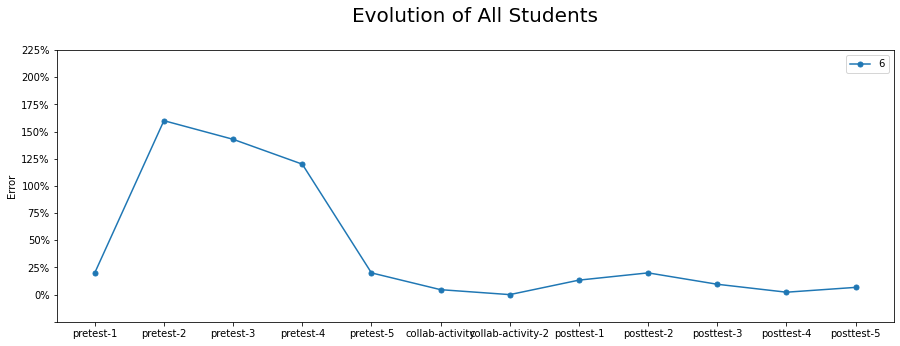

In [56]:
test = evolution_dfs[9]

# helper function to graph each student dataframe on same plot, takes dataframe as input
def generate_visualization(df):
    temp = df

    # visualization for error evolution over the best submission in each collaborative activity
    students = [1, 2, 3, 4, 5, 6, 7, 9, 10]
    separation = 0.01

    # graphing the pretest versus posttest is_spanning scores
    plt.plot(temp.activity, temp.error, marker='o', markersize=5)
    fig = plt.gcf()
    fig.set_size_inches(15, 5)
    
    plt.ylabel('Error')
    title = "Evolution of All Students\n"
    plt.title(title, loc='center', fontsize=20)

    leg = plt.legend(evolution_dfs.keys(), loc='upper right', frameon=True)

    # ensure that y-axis labelling is proportional to maximum possible error 
    plt.ylim(-0.1, max_error[1])
    locs,labels = plt.yticks()
    labels = [str(round(i*100)) + '%' for i in locs]
    labels[0] = ''
    plt.yticks(locs,labels)

generate_visualization(test)

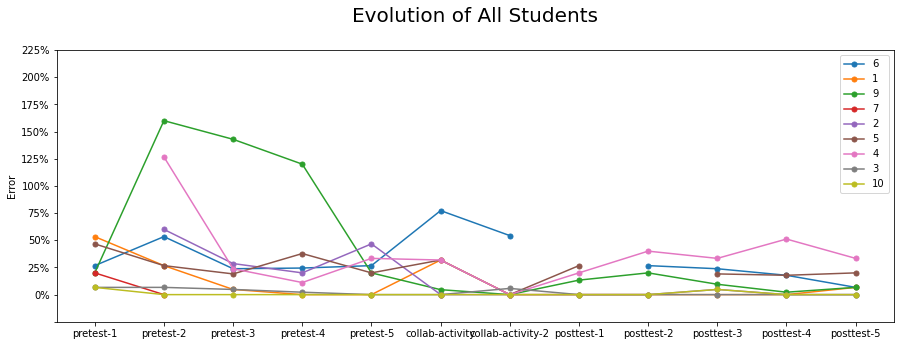

In [57]:
for student, df in evolution_dfs.items():
    generate_visualization(df)


# Find task intervals for all logs from their tables.
- slicers: put markers or checkpoints that point to the start and end of an activity
    - intervals dict for each student with start and end timestamps tuples
    - confirm the checkpoints: delete overlap and check contiguity and continuity
    
- One way to have a simpler check is to count number of transitions into that activity and move on if it is one, handle the case if it is more than one (for the case of going into and out from that activity).


In [92]:
# return the task interval times and handle cleaning from discontinuous log errors
def find_task_intervals(df, task):
    df = df.copy()
    df = df.loc[df['header.frame_id'] == task]
    start = df.iloc[0]['Time']
    end = df.iloc[-1]['Time']
    return start, end

headers = ['pretest-1', 'pretest-2', 'pretest-3', 'pretest-4', 'pretest-5', 'collab-activity',
           'collab-activity-2', 'posttest-1', 'posttest-2', 'posttest-3', 'posttest-4', 'posttest-5']

# log the start and end times of every task for every student
student_intervals = {}
for student, table in processed_tables.items():
    intervals = {}
    for i in headers:
        start, end = find_task_intervals(table.copy(), i)
        intervals[i] = (start, end)
    student_intervals[student] = intervals
#print(student_intervals)

for student,values in student_intervals.items():
    print(student, values)
    
    for test,times in values.items():
        start,end = values[test]
        print(start,end,'\n')
        
        #check the end time of pretest-1 with the start time of pretest-2
        #if above threshold of 
        break


6 {'pretest-1': (107.78392219543456, 167.10686135292053), 'pretest-2': (195.68815732002255, 230.0998957157135), 'pretest-3': (251.1525661945343, 289.6736686229706), 'pretest-4': (314.58395075798035, 360.7600588798523), 'pretest-5': (380.4511823654175, 423.1908950805664), 'collab-activity': (727.2702190876007, 2235.430909395218), 'collab-activity-2': (2282.949033498764, 3404.7349185943604), 'posttest-1': (3639.168105602264, 3670.641201496124), 'posttest-2': (3684.864453077316, 3714.0895581245422), 'posttest-3': (3726.333530187607, 3757.8723559379578), 'posttest-4': (3772.7371962070474, 3805.1794571876526), 'posttest-5': (3815.6659920215607, 3868.023068666458)}
107.78392219543456 167.10686135292053 

1 {'pretest-1': (96.4143397808075, 161.27743887901306), 'pretest-2': (184.98478150367737, 251.00974297523496), 'pretest-3': (273.7148389816284, 319.2249743938446), 'pretest-4': (341.8985347747803, 386.28241419792175), 'pretest-5': (404.6526141166687, 435.3684105873108), 'collab-activity': (4

In [117]:
def gantt_chart(df):
    
    # Declaring a figure "gnt" 
    fig, gnt = plt.subplots() 

    # Setting Y-axis limits 
    gnt.set_ylim(0, 100) 

    # Setting X-axis limits 
    gnt.set_xlim(0, 4000) 

    # Setting labels for x-axis and y-axis 
    gnt.set_xlabel('seconds since start') 
    gnt.set_ylabel('Activity') 

    # Setting ticks on y-axis 
    gnt.set_yticks([15, 25, 35, 45, 55, 65, 75, 85, 95,105,115,125]) 
    # Labelling tickes of y-axis 
    gnt.set_yticklabels(['pretest-1', 'pretest-2', 'pretest-3', 'pretest-4', 'pretest-5', 'collab-activity', 'collab-activity-2', 'posttest-1', 'posttest-2', 'posttest-3', 'posttest-4', 'posttest-5']) 

    # Setting graph attribute 
    gnt.grid(True) 

    # Declaring all the bars for each activity 
    for i in range(len(df)):
        gnt.broken_barh([(df.loc[i,'start'], df.loc[i,'duration'])], ((i+1)*10, 9), facecolors =('tab:red')) 

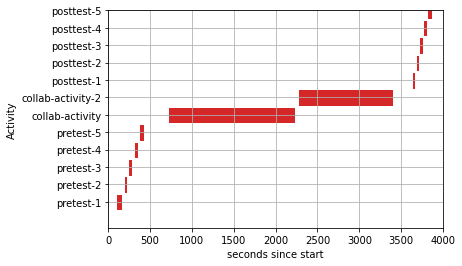

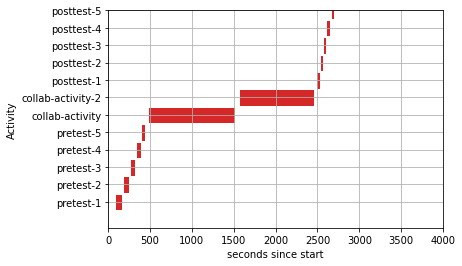

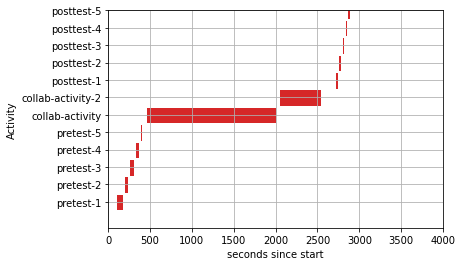

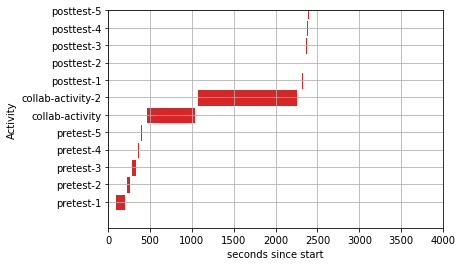

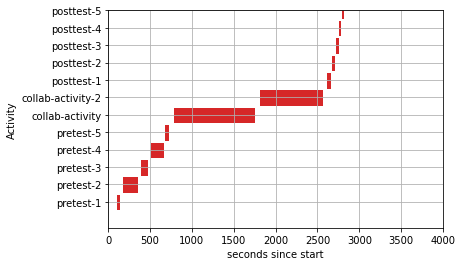

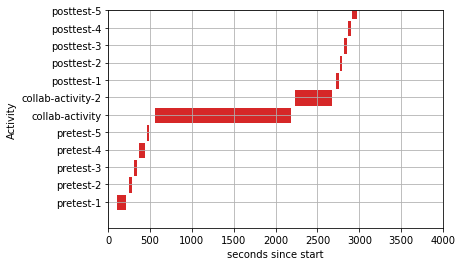

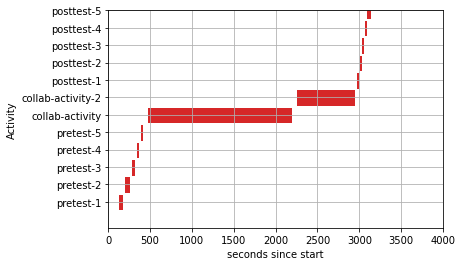

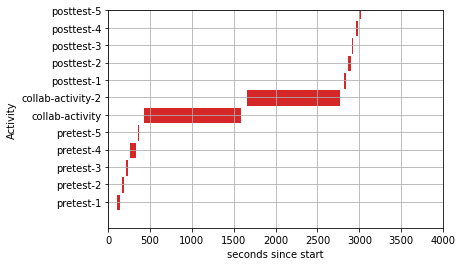

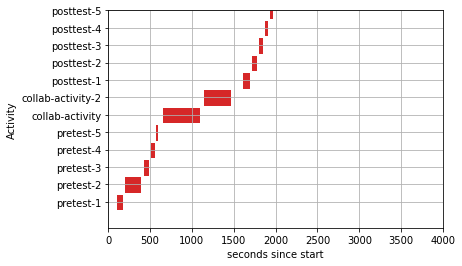

In [119]:
time_df = pd.DataFrame()

for student,values in student_intervals.items():
    #time_df = pd.DataFrame.from_dict(values)
    time_df['activity'] = values.keys()
    times = values.values()
    start = []
    end = []
    duration = []
    for i in times:
        s,e = i
        start.append(s)
        end.append(e) 
        duration.append(e-s)
    time_df['start'] = start
#     time_df['end'] = end
    time_df['duration'] = duration
#     display(time_df)
    
    gantt_chart(time_df)

# Evolution across human actions in a collaborative activity.

S = optimal suggestions by the human
A = optimal agreements by the human
D = optimal disagreements by the human


In [231]:
action_type_dict = {
    'TYPE_SUGGEST_PICK': 0,
    'TYPE_PICK': 1,
    'TYPE_UNPICK': 2,
    'TYPE_SUBMIT': 3,
    'TYPE_SUGGEST_SUBMIT': 4,
    'TYPE_CLEAR_SUGGEST_SUBMIT': 5,
    'TYPE_AGREE': 6,
    'TYPE_DISAGREE': 7,
    'TYPE_CLEAR': 8,
    'TYPE_GUESS': 9}

In [269]:
pd.options.display.max_rows = None
processed_tables[6]

,Time,header.seq,header.frame_id,state.edges,state.suggested.u,state.suggested.v,state.terminal,state.submit_suggested,action.agent_name,action.type,action.edge.u,action.edge.v,next_state.edges,next_state.suggested.u,next_state.suggested.v,next_state.terminal,next_state.submit_suggested,action_no,step_no,turn_agent,world_state,action,is_submission,cost,is_mst
0,0.000000,1,indiv-illustrate,[],-1,-1,False,False,human,1,9,1,[u: 9\nv: 1],-1,-1,False,False,0,1,human,"WorldState(n:2,e:1|e:0,c:0,s:False,t:False)","pick(9,1)",False,0,False
1,37.186259,2,indiv-illustrate,[u: 9\nv: 1],-1,-1,False,False,human,8,-1,-1,[],-1,-1,False,False,1,2,human,"WorldState(n:2,e:1|e:1,c:3,s:True,t:False)",clear,False,3,True
2,66.840281,3,indiv-illustrate,[],-1,-1,False,False,human,1,9,1,[u: 9\nv: 1],-1,-1,False,False,2,3,human,"WorldState(n:2,e:1|e:0,c:0,s:False,t:False)","pick(9,1)",False,0,False
3,69.357834,4,indiv-illustrate,[u: 9\nv: 1],-1,-1,False,False,human,3,-1,-1,[u: 9\nv: 1],-1,-1,True,False,3,4,human,"WorldState(n:2,e:1|e:1,c:3,s:True,t:False)",submit,False,3,True
4,107.783922,5,pretest-1,[],-1,-1,False,False,human,1,0,7,[u: 0\nv: 7],-1,-1,False,False,0,0,human,"WorldState(n:7,e:12|e:0,c:0,s:False,t:False)","pick(0,7)",False,0,False
5,112.581371,6,pretest-1,[u: 0\nv: 7],-1,-1,False,False,human,1,7,6,"[u: 0\nv: 7, u: 7\nv: 6]",-1,-1,False,False,1,0,human,"WorldState(n:7,e:12|e:1,c:4,s:False,t:False)","pick(7,6)",False,4,False
6,118.116938,7,pretest-1,"[u: 0\nv: 7, u: 7\nv: 6]",-1,-1,False,False,human,1,6,4,"[u: 0\nv: 7, u: 7\nv: 6, u: 6\nv: 4]",-1,-1,False,False,2,0,human,"WorldState(n:7,e:12|e:2,c:6,s:False,t:False)","pick(6,4)",False,6,False
7,125.957355,8,pretest-1,"[u: 0\nv: 7, u: 7\nv: 6, u: 6\nv: 4]",-1,-1,False,False,human,1,4,1,"[u: 0\nv: 7, u: 7\nv: 6, u: 4\nv: 1, u: 6\nv: 4]",-1,-1,False,False,3,0,human,"WorldState(n:7,e:12|e:3,c:8,s:False,t:False)","pick(4,1)",False,8,False
8,148.255543,9,pretest-1,"[u: 0\nv: 7, u: 7\nv: 6, u: 4\nv: 1, u: 6\nv: 4]",-1,-1,False,False,human,1,4,5,"[u: 0\nv: 7, u: 4\nv: 5, u: 7\nv: 6, u: 4\nv: ...",-1,-1,False,False,4,0,human,"WorldState(n:7,e:12|e:4,c:11,s:False,t:False)","pick(4,5)",False,11,False
9,155.006081,10,pretest-1,"[u: 0\nv: 7, u: 4\nv: 5, u: 7\nv: 6, u: 4\nv: ...",-1,-1,False,False,human,1,1,3,"[u: 0\nv: 7, u: 4\nv: 5, u: 7\nv: 6, u: 1\nv: ...",-1,-1,False,False,5,0,human,"WorldState(n:7,e:12|e:5,c:13,s:False,t:False)","pick(1,3)",False,13,False


In [266]:
a = processed_tables[1]

a = a.loc[a['action.agent_name'] == 'human']
a = a.loc[a['action.type'] == 0]
display(a)

d



,Time,header.seq,header.frame_id,state.edges,state.suggested.u,state.suggested.v,state.terminal,state.submit_suggested,action.agent_name,action.type,action.edge.u,action.edge.v,next_state.edges,next_state.suggested.u,next_state.suggested.v,next_state.terminal,next_state.submit_suggested,action_no,step_no,turn_agent,world_state,action,is_submission,cost,is_mst
49,528.439899,50,collab-activity,[u: 0\nv: 3],-1,-1,False,False,human,0,2,1,[u: 0\nv: 3],2,1,False,False,2,1,robot,"WorldState(n:10,e:20|e:1,c:3,s:False,t:False)","suggest-pick(2,1)",False,3,False
53,569.412335,54,collab-activity,"[u: 2\nv: 3, u: 0\nv: 3, u: 2\nv: 1]",-1,-1,False,False,human,0,8,9,"[u: 2\nv: 3, u: 0\nv: 3, u: 2\nv: 1]",8,9,False,False,6,1,robot,"WorldState(n:10,e:20|e:3,c:8,s:False,t:False)","suggest-pick(8,9)",False,8,False
57,615.240996,58,collab-activity,"[u: 2\nv: 3, u: 8\nv: 9, u: 2\nv: 1, u: 8\nv: ...",-1,-1,False,False,human,0,5,4,"[u: 2\nv: 1, u: 0\nv: 3, u: 2\nv: 3, u: 8\nv: ...",5,4,False,False,10,1,robot,"WorldState(n:10,e:20|e:5,c:13,s:False,t:False)","suggest-pick(5,4)",False,13,False
61,660.352259,62,collab-activity,"[u: 2\nv: 3, u: 8\nv: 9, u: 2\nv: 1, u: 8\nv: ...",-1,-1,False,False,human,0,6,4,"[u: 2\nv: 1, u: 5\nv: 4, u: 0\nv: 3, u: 5\nv: ...",6,4,False,False,14,1,robot,"WorldState(n:10,e:20|e:7,c:18,s:False,t:False)","suggest-pick(6,4)",False,18,False
65,702.448704,66,collab-activity,"[u: 2\nv: 1, u: 5\nv: 4, u: 0\nv: 3, u: 6\nv: ...",-1,-1,False,False,human,0,1,4,"[u: 2\nv: 1, u: 5\nv: 4, u: 0\nv: 3, u: 6\nv: ...",1,4,False,False,18,1,robot,"WorldState(n:10,e:20|e:9,c:22,s:False,t:False)","suggest-pick(1,4)",False,22,False
68,743.720036,69,collab-activity,"[u: 2\nv: 1, u: 5\nv: 4, u: 0\nv: 3, u: 6\nv: ...",-1,-1,False,False,human,0,1,9,"[u: 2\nv: 1, u: 5\nv: 4, u: 0\nv: 3, u: 6\nv: ...",1,9,False,False,21,1,robot,"WorldState(n:10,e:20|e:10,c:25,s:False,t:False)","suggest-pick(1,9)",False,25,False
72,788.101511,73,collab-activity,"[u: 2\nv: 1, u: 5\nv: 4, u: 0\nv: 3, u: 6\nv: ...",-1,-1,False,False,human,0,4,9,"[u: 2\nv: 1, u: 5\nv: 4, u: 0\nv: 3, u: 6\nv: ...",4,9,False,False,25,1,robot,"WorldState(n:10,e:20|e:11,c:28,s:False,t:False)","suggest-pick(4,9)",False,28,False
75,825.171204,76,collab-activity,"[u: 2\nv: 1, u: 4\nv: 1, u: 5\nv: 4, u: 0\nv: ...",-1,-1,False,False,human,0,7,0,"[u: 1\nv: 3, u: 2\nv: 1, u: 5\nv: 4, u: 0\nv: ...",7,0,False,False,28,1,robot,"WorldState(n:10,e:20|e:12,c:31,s:True,t:False)","suggest-pick(7,0)",False,31,False
79,864.934668,80,collab-activity,"[u: 2\nv: 1, u: 4\nv: 1, u: 5\nv: 4, u: 0\nv: ...",-1,-1,False,False,human,0,4,9,"[u: 1\nv: 3, u: 2\nv: 1, u: 5\nv: 4, u: 0\nv: ...",4,9,False,False,32,1,robot,"WorldState(n:10,e:20|e:13,c:35,s:True,t:False)","suggest-pick(4,9)",False,35,False
85,911.124619,86,collab-activity,[u: 4\nv: 5],-1,-1,False,False,human,0,6,4,[u: 4\nv: 5],6,4,False,False,38,1,robot,"WorldState(n:10,e:20|e:1,c:2,s:False,t:False)","suggest-pick(6,4)",False,2,False


,Time_x,header.seq_x,header.frame_id_x,state.edges_x,state.suggested.u_x,state.suggested.v_x,state.terminal_x,state.submit_suggested_x,action.agent_name_x,action.type_x,action.edge.u_x,action.edge.v_x,next_state.edges_x,next_state.suggested.u_x,next_state.suggested.v_x,next_state.terminal_x,next_state.submit_suggested_x,action_no_x,step_no_x,turn_agent_x,world_state_x,action_x,is_submission_x,cost_x,is_mst_x,Time_y,header.seq_y,header.frame_id_y,state.edges_y,state.suggested.u_y,state.suggested.v_y,state.terminal_y,state.submit_suggested_y,action.agent_name_y,action.type_y,action.edge.u_y,action.edge.v_y,next_state.edges_y,next_state.suggested.u_y,next_state.suggested.v_y,next_state.terminal_y,next_state.submit_suggested_y,action_no_y,step_no_y,turn_agent_y,world_state_y,action_y,is_submission_y,cost_y,is_mst_y


In [262]:
sad_dict = {}

for student, df in processed_tables.items():
    #dict for SAD per student
    sad = {}
    
    #optimal suggestions S
    #check human agent
    #check action.type == 0
    S = df.loc[df['action.agent_name'] == 'human']
    S = S.loc[S['action.type'] == 0]
    sad['S'] = S
#     display(S)
    

    #optimal agreements A
    #check human agent
    #check action.type == 6
    A = df.loc[df['action.agent_name'] == 'human']
    A = A.loc[A['action.type'] == 6]
    sad['A'] = A
#     display(A)

    #optimal disagreement D
    #check human agent
    #check action.type == 7
    D = df.loc[df['action.agent_name'] == 'human']
    D = D.loc[D['action.type'] == 7]
    sad['D'] = D
#     display(D)

    sad_dict[student] = sad
    

In [281]:
# qualify the actions in terms of optimality (does the edge the student picked belong to the mst) True or False
# making network files for an activity

resources_dir = pl.Path('resources')
networks_dir = resources_dir.joinpath('networks')
tables_dir = pl.Path('../processed_data/log_tables')

def make_network_files(name, networks_dir):
    network_file = networks_dir.joinpath('{}_edgelist.txt'.format(name))
    layout_file = networks_dir.joinpath('{}_layout.json'.format(name))
    return {'network_file': network_file, 'layout_file': layout_file}

test_submit_mode = 'once'
problems = {}

test_actions = ['pick', 'unpick', 'suggest-submit']
activity_actions = ['suggest-pick', 'submit']

for test in ['pretest', 'posttest']:
    for i in range(1, 6):
        name = '{}-{}'.format(test, i)

        problems[name] = init_problem(
            **make_network_files(name, networks_dir),
            action_types=test_actions,
            submit_mode=test_submit_mode)
name = 'collab-activity'
problems[name] = init_problem(
    **make_network_files(name, networks_dir),
    action_types=activity_actions)
name = 'collab-activity-2'
problems[name] = init_problem(
    **make_network_files(name, networks_dir),
    action_types=activity_actions)

problems[name].env.state.graph.edges(data=True)
help(problems[name].env.state)

# optimal reaction to the suggestions: did the student agree/disagree to the robot’s suggestion correctly?
# function that checks if the action is optimal or not when given the state and action


Help on WorldState in module justhink_problem.domain.state object:

class WorldState(pomdp_py.framework.basics.State)
 |  WorldState(graph, edges=frozenset(), suggested=None, submit_suggested=False, terminal=False)
 |  
 |  A class used to represent a world state
 |  for a minimum-spanning tree problem
 |  
 |  Attributes
 |  ----------
 |  graph : networkx.Graph
 |     the network with a cost function on edges
 |  edges : set
 |     the set of selected edges in the network
 |  terminal : str
 |     the sound that the animal makes
 |  num_legs : int
 |     the number of legs the animal has (default 4)
 |  
 |  Methods
 |  -------
 |  says(sound=None)
 |     Prints the animals name and what sound it makes
 |  
 |  Method resolution order:
 |      WorldState
 |      pomdp_py.framework.basics.State
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __eq__(self, other)
 |      Return self==value.
 |  
 |  __hash__(self)
 |      Return hash(self).
 |  
 |  __init__(self, graph,

# Descripitive statistics accross all activities.
- min max and mean (standard dev) duration & number of actions for every test/activity/attempt
    - box plots